In [1]:
import pandas as pd
import os
import pickle

In [4]:
#Download the initial test statistics
df = pd.read_csv('Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)


### Reading in the files

Used to test the code I use for the HPC

In [2]:
os.getcwd()

'c:\\Users\\jenna\\Documents\\Imperial\\Project_2\\Code'

In [3]:
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
#path = os.getcwd() + '\\Data\\permutation_test_files_proteomics'
#path = os.getcwd() + '\\Data\\permutation_test_files_integrated'

Read all the files that start with 'Run' inside a folder:

In [4]:
final_list = []

for filename in os.listdir(path): #also lists directories
    if filename.startswith('Run'):
        file_num = int(filename[3:-4])  #obtain the number of the Run
        if file_num < 11:
            print(filename)
            with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

Run1.txt
Run2.txt


Read all the files in a folder that starts with 'Results':

In [5]:
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
final_list = []

for filename in os.listdir(path): #also lists directories
    if filename.startswith('Results'):
        print(filename)
        #for file in os.listdir(path + '\\' + filename): 
        for file in os.listdir(os.path.join(path,filename)):
            print(file)
            with open(os.path.join(path, filename,file), 'rb') as file: # open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

Results1
Run11.txt
Run12.txt
Results2
Run13.txt
Run14.txt


In a folder with directories list (Results1, Results2, Results3 etc) go through each as a separate array job:


In [ ]:
#index_num = sys.argv[1]  #this should return the array number within the array job
index_num = 1 #for example
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics\\Results' + str(index_num)
final_list = []

for filename in os.listdir(path): #also lists directories
    print(filename)
    with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
        list1 = pickle.load(file)
    final_list.append(list1)

In [ ]:
len(final_list)

for list1 in final_list:
    print(len(list1))
    print(list1[:3])

### Calculate which edges are significant

Calculates number of permuted values above the initial test statistic, then divides by number of tests and works out p-value, before outputting the significant edges: (NOT RECOMMENDED, p-values not FDR corrected)

In [ ]:
sig_edges = []
edgelist = df.index

for index,pathway_pair in enumerate(edgelist):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    counter = 0
    
    for list1 in final_list:  #len(final_list) = number of permutations
        if abs(list1[index]) >= comparison:   
            counter += 1
    
    p_val = (counter/len(final_list))    #divide number of tests above or equal to the test statistic by total number of tests

    if p_val < 0.01:  #for 100,000 permutations
        sig_edges.append(pathway_pair)  
        
print(len(sig_edges))
sig_edges

Calculates number of permuted values above the initial test statistic (more scalable)

In [ ]:
num_vals = []  #number of permuted values above the magnitude of the test statistic
#sig_edges = []
edgelist = df.index

for index in range(len(edgelist)):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    print(comparison)
    counter = 0
    
    for list1 in final_list:  #len(final_list) = number of permutations
        if abs(list1[index]) >= comparison:   
            counter += 1
    num_vals.append(counter)

num_vals

### Another alternative: (but converting to numpy array actually seems to take up more memory)

In [ ]:
import numpy as np

final_matrix = np.empty((0,len(df)), int)

for filename in os.listdir(path):
    if filename != 'initial_tstats.csv':
        with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
            list1 = pickle.load(file)
        final_matrix = np.append(final_matrix, np.array([list1]), axis=0)

In [ ]:
final_matrix.shape

In [ ]:
final_matrix = np.array(final_list) 

final_matrix.shape

sig_edges = []
edgelist = df.index

for index,pathway_pair in enumerate(edgelist):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    counter = 0
    
    col = abs(final_matrix[:,index])  #index a column and turn into absolute values
    counter = (col >= comparison).sum()

    
    p_val = (counter/len(final_list))    #divide number of tests above or equal to the test statistic by total number of tests

    if p_val < 0.01:  #for 100,000 permutations
        sig_edges.append(pathway_pair)  
        
print(len(sig_edges))

In [ ]:
#comparing the size of the object from the first method vs second method ()
from sys import getsizeof
print(getsizeof(final_list))
print(getsizeof(final_matrix))

Saving the file:

In [ ]:
with open ('Data/permutation_test_files_metabolomics/vals_test.txt', 'w') as file:
     file.write(','.join(str(i) for i in num_vals))

### Read in HPC results (reading ten files):

In [1]:
import os 
import numpy as np 
import statsmodels.stats.multitest
import pandas as pd
from itertools import compress

import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
#Read ten files that have the number of edges that are of a higher value that the initial test statistic

#path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics\\Values'
#path = os.getcwd() + '\\Data\\permutation_test_files_proteomics\\Values'
path = os.getcwd() + '\\Data\\permutation_test_files_integrated\\Values'
val_array = []


for filename in os.listdir(path): #also lists directories
    with open(os.path.join(path, filename)) as file:    
        lines = file.readlines()
        vals = lines[0].split(';')
        vals =  [int(x) for x in vals]
        #print(vals)
        if filename == 'vals1.txt':
            val_array = np.array(vals)
        else:
            val_array = np.vstack([val_array, vals])

In [37]:
val_array
val_array2 = val_array.sum(axis=0) #add up the values by columns for each pathway pair
pval_array = val_array2 / 100000
pval_array[:20]

print(len(pval_array)) #10,296 for metabolomic,166753 values for proteomic, 251,695 values for integrated
(pval_array < 0.05).sum() #763 for metabolomic, 58,115 values for proteomic, 68,299 values for integrated

#Before I realised I forgot to scale: #56256 values for proteomic, 65,208 values for integrated

251695


68299

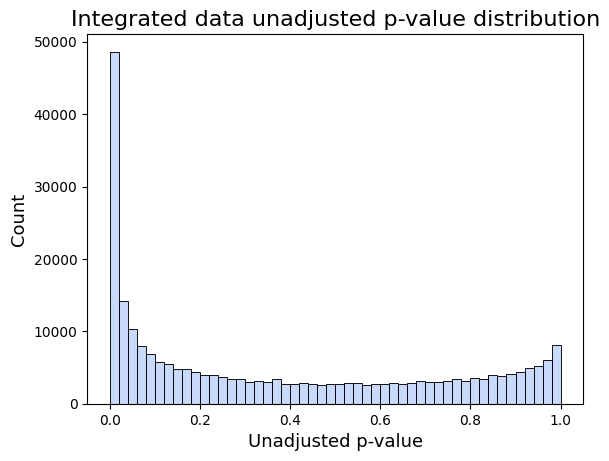

In [38]:
sns.histplot(pval_array, bins = 50,color='#B8CDF8',edgecolor="k") 

#plt.title('Metabolomic data unadjusted p-value distribution',fontsize=16)
#plt.title('Proteomic unadjusted p-value distribution',fontsize=16)
plt.title('Integrated data unadjusted p-value distribution',fontsize=16)

plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/unadjusted_pval_metabolomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/unadjusted_pval_proteomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/unadjusted_pval_integrated.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [39]:
sig_edge_boolean,adjusted_pval = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.05, method='poscorr', is_sorted=False)
sig_edge_boolean

array([False, False, False, ..., False, False,  True])

In [40]:
sig_edge_boolean2,adjusted_pval2 = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.05, method='indep', is_sorted=False)
sig_edge_boolean2

array([False, False, False, ..., False, False,  True])

In [41]:
print(adjusted_pval)
print(adjusted_pval2)

[0.36794781 0.07924384 0.25630682 ... 0.07733926 0.05787652 0.03105318]
[0.36794781 0.07924384 0.25630682 ... 0.07733926 0.05787652 0.03105318]


In [42]:
sig_edge_boolean == sig_edge_boolean2
np.array_equiv(sig_edge_boolean,sig_edge_boolean2)

True

In [43]:
adjusted_pval

array([0.36794781, 0.07924384, 0.25630682, ..., 0.07733926, 0.05787652,
       0.03105318])

In [44]:
sum(sig_edge_boolean) 
#Metabolomic - 8 edges significant with method=indep and method=poscorr
#Proteomic - 31486 edges significant with method=indep and method=poscorr
#Integrated - 26761 edges significant with method=indep and method=poscorr (less than proteomic because more edges so penalised more heavily)

#Before I realised I forgot to scale:
#Proteomic - 29327 edges significant with method=indep and method=poscorr
#Metabolomic - 24600 edges significant with method=indep and method=poscorr

26761

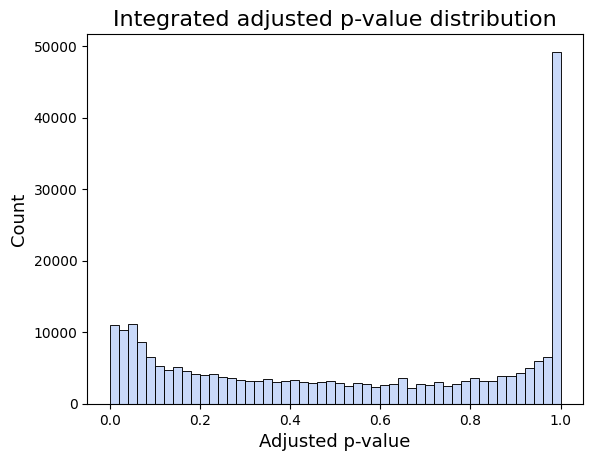

In [45]:
sns.histplot(adjusted_pval, bins = 50,color='#B8CDF8',edgecolor="k") 

#plt.title('Metabolomic adjusted p-value distribution',fontsize=16)
#plt.title('Proteomic adjusted p-value distribution',fontsize=16)
plt.title('Integrated adjusted p-value distribution',fontsize=16)

plt.xlabel('Adjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/adjusted_pval_metabolomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/adjusted_pval_proteomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/adjusted_pval_integrated.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')



Easier to obtain the reverse (i.e. edges that are not significant), since then they can be removed easily

In [46]:
not_sig_edge_boolean = [not elem for elem in sig_edge_boolean]
sum(not_sig_edge_boolean )

224934

In [47]:
#Load dataset
#df = pd.read_csv('Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)
df = pd.read_csv('Data/permutation_test_files_integrated/initial_tstats.csv', index_col=0)
edgelist = df.index


sig_edges = list(compress(edgelist,sig_edge_boolean))
not_sig_edges = list(compress(edgelist,not_sig_edge_boolean))

Saving the significant edges: Easier to compare with the naive networks and the other omics networks as well <br>
Saving the non-significant edges: Easier when constructing the differential network analysis

In [19]:
#with open ('Data/permutation_test_files_metabolomics/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('Data/permutation_test_files_metabolomics/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

In [20]:
#Save number of significant edges BEFORE FDR CORRECTION

#sig_edges_beforefdr = list(compress(edgelist,pval_array < 0.05))
#print(len(sig_edges_beforefdr))

#with open ('Data/permutation_test_files_metabolomics/sig_edges_beforefdr.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges_beforefdr))

763


In [33]:
#with open ('Data/permutation_test_files_proteomics/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('Data/permutation_test_files_proteomics/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

In [48]:
#with open ('Data/permutation_test_files_integrated/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('Data/permutation_test_files_integrated/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

### Plotting the test statistic distribution for randomly chosen pathway pairs


In [171]:
import pandas as pd
import os
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
#Download the initial test statistics
#df = pd.read_csv('Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
df = pd.read_csv('Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('Data/permutation_test_files_integrated/initial_tstats.csv', index_col=0)


#path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
path = os.getcwd() + '\\Data\\permutation_test_files_proteomics'
#path = os.getcwd() + '\\Data\\permutation_test_files_integrated'

In [ ]:
df

Selecting random pathways and writing to a file without the HPC:

In [ ]:


#pathway_list = []

#for i in range(8): #take 8 random pathways
#    index = random.randrange(0, len(df)) #Gives index from 0 to (len(df)-1), better for indexing with unpickled files which are stored as lists
#    print(index)
#    for filename in os.listdir(path):
#            if filename.startswith('Run'):
#                with open(os.path.join(path, filename),'rb') as file:
#                    list1 = pickle.load(file)   
#                    #print(len(list1))
#                    pathway_list.append(list1[index])
#    with open('Data/permutation_test_files_metabolomics/test_distribution'+str(index)+'.txt', 'w') as file:
#        file.write(','.join(str(i) for i in pathway_list))
#    print(len(pathway_list))
#    pathway_list = []




Read in the test distribution files that were made from the HPC and plotting:

100000
[-0.022924406362944086, 0.4408597013648855, 0.12051523890334495, 0.267105775951159, -0.054259821745759225, 0.41774917324531113, 0.15142849411913167, 0.3389295604726258, -0.12233999512753434, -0.09925803306271958, 0.04658955105687877, 0.024708082400899407, -0.058874491122430254, -0.11705154129473348, -0.24669517006146305, 0.3679570653519134, -0.035273258827077304, 0.4033331758442678, -0.13071310650110116, -0.09534967318639084, -0.033065029751865545, -0.07600305546537052, 0.2752772078454505, -0.15270615714384608, 0.22816688749954636, -0.05911216112885938, 0.29200593067592956, -0.007031830183731061, -0.04853262612595483, 0.1613695560489054, 0.13788513148603498, -0.25604799072119666, 0.026561223578473667, -0.08460959756253351, 0.1914874484864577, -0.07695685573062055, 0.0484483876163372, 0.020958628512594946, -0.12552669422258428, 0.3158818883024828, -0.0972972578957012, -0.10084439865983873, 0.12150378066529881, -0.11859306329679785, 0.1807338149619865, -0.06672062793770567, 0.0266

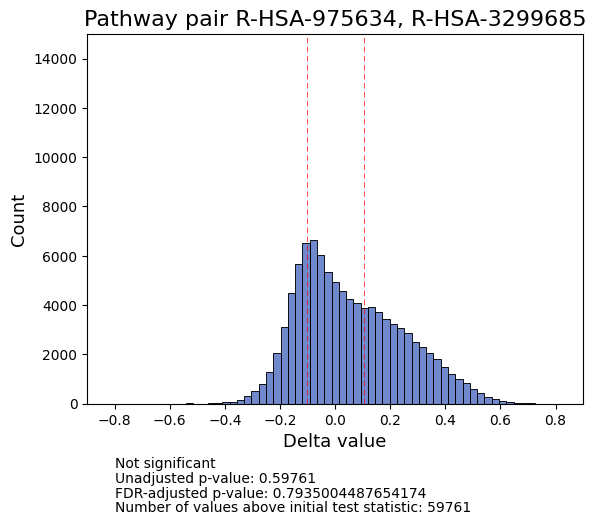

In [190]:
val_array = []


#Run all the test distribution files:
#for filename in os.listdir(path): #also lists directories
#    if filename.startswith('test'):
#        with open(os.path.join(path, filename)) as file:    
#            lines = file.readlines()
#            vals = lines[0].split(',')
#            vals =  [float(x) for x in vals]
#            print(len(vals))
#            print(vals[:100])
            

#I've plotted figures for the following (metabolomics): 219 (sig before correction), 1284, 3361 (sig before correction), 3919, 3966, 4078 (sig before correction), 4443, 5933, 6060, 8071
#I've plotted figures for the following (proteomics): 2573 (weird bimodal distribution), 25496, 66155, 67596 (sig before correction), 100389, 124007 (sig), 133091, 135536 (weird bimodal distribution), 157858
#I've plotted figures for the following (integrated): 13134, 17265, 20660, 65871 (sig), 71456, 74104, 83071 (sig before correction), 85546, 150704 (sig before correction), 251461

#Open the test distribution files one by one:
test_num = 157858
#with open('Data/permutation_test_files_metabolomics/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
with open('Data/permutation_test_files_proteomics/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
#with open('Data/permutation_test_files_integrated/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
    comparison = df.Initial_tstat[test_num]
    edge_name = df.index[test_num]

    lines = file.readlines()
    vals = lines[0].split(',')
    vals =  [float(x) for x in vals]
    print(len(vals))
    print(vals[:100])


#For metabolomics:
#sns.histplot(vals, bins = 50,color='#59C3C3',edgecolor="k") 

#For proteomics:
sns.histplot(vals, bins = 50,color='#4062BB',edgecolor="k") 

#For integrated data:
#sns.histplot(vals, bins = 50,color='#52489C',edgecolor="k") 


plt.title('Pathway pair '+ edge_name,fontsize=16)
plt.xlabel('Delta value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

plt.axvline(x=comparison, color='r', linewidth=0.5, linestyle='--', dashes=(8, 5))
plt.axvline(x=-comparison, color='r', linewidth=0.5, linestyle='--', dashes=(8, 5))

#Count number of values (made absolute) that are over the initial test statistic (made absolute) for two sided permutation test
counter = 0 
for index in range(len(vals)):  #len(final_list) = number of permutations
    if abs(vals[index]) >= comparison:   
        counter += 1
print(counter)


#MUST RUN THE ABOVE CODE TO LOAD IN THE NUMBER OF VALUES THAT ARE ABOVE THE INITIAL TEST STATISTIC SO I KNOW WHETHER THE PATHWAY PAIR IS SIGNIFICANT AFTER FDR CORRECTION
if sig_edge_boolean[test_num] == True:
    plt.text(-0.8, -2600, "Adjusted p-value significant",fontsize=10)
else:
    plt.text(-0.8, -2600, "Not significant",fontsize=10)
plt.text(-0.8, -3200, "Unadjusted p-value: " + str(pval_array[test_num]),fontsize=10)
plt.text(-0.8, -3800, "FDR-adjusted p-value: " + str(adjusted_pval[test_num]),fontsize=10)
plt.text(-0.8, -4400, "Number of values above initial test statistic: " + str(counter),fontsize=10)



plt.xlim(-0.9,0.9)   #-log_10(0.005) = 2.301...
plt.ylim(0,15000) 

#plt.savefig( 'Figures/Pathway ' + edge_name + '.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')